In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
import requests
import tweepy
from textblob import TextBlob
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from datetime import datetime
sns.set_theme(style="darkgrid")

In [20]:
def api_req(url,params):
    response = requests.get(url, params=params)
    # Parse response
    data = response.json()['Data']['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = pd.to_datetime(df['time'], unit='s')
    df = df.sort_values(by='timestamp',ascending=False)
    df.drop(df.head(1).index,inplace=True)
    return df

In [24]:
# Only run this cell if updating the model with new data
url = 'https://min-api.cryptocompare.com/data/v2/histoday'
params = {
    'api_key':'4f5cd6a090d066496f7a74d6a33ef6913ef96807d2d33f5c47e50f7b011bf2be',
    'fsym': 'BTC',
    'tsym': 'USD',
    'limit': 1999 # Get data for the past year
}
df = api_req(url,params)
df.head()

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,timestamp
1998,1680566400,28437.75,27674.33,27810.08,33855.00,9.519132e+08,28178.13,direct,,2023-04-04
1997,1680480000,28494.64,27290.26,28186.76,52416.66,1.467725e+09,27810.08,direct,,2023-04-03
1996,1680393600,28538.36,27880.95,28465.30,21016.25,5.925811e+08,28186.76,direct,,2023-04-02
1995,1680307200,28810.95,28265.42,28477.29,19774.03,5.632994e+08,28465.30,direct,,2023-04-01
1994,1680220800,28650.47,27541.23,28037.46,50916.39,1.436740e+09,28477.29,direct,,2023-03-31


In [ ]:
df = pd.read_csv('btc-daily-price.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

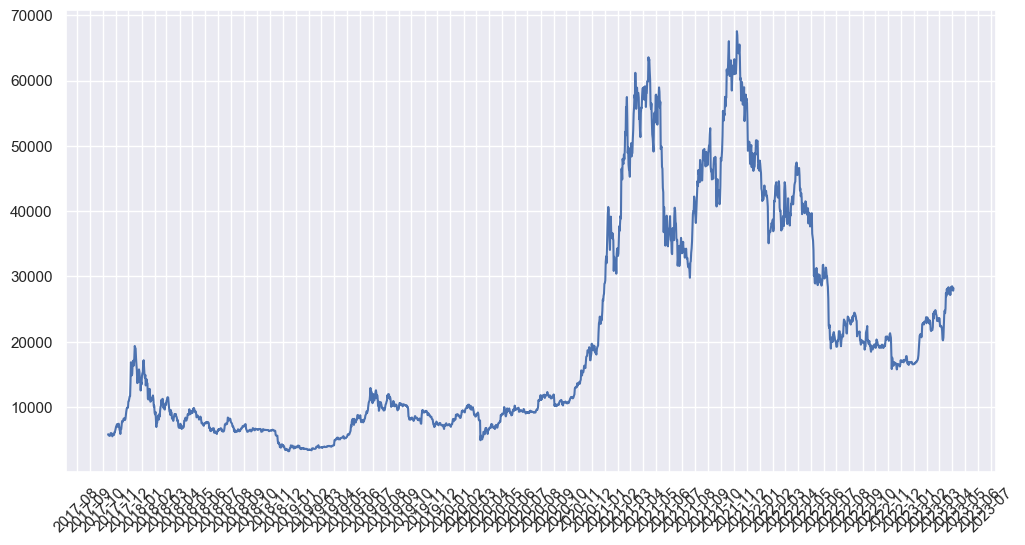

In [58]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df['timestamp'], df['close'])
# format the x axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# set the tick locator to show ticks at the start of each month
ax.xaxis.set_major_locator(mdates.MonthLocator())

# set the tick labels to show only the month and year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# set the rotation of the tick labels
plt.xticks(rotation=45)
plt.show()

In [66]:
# clean data for modelling
df = df[['timestamp', 'close']]
df.columns = ['ds', 'y']
df = df.dropna()

In [73]:
df.head()

,ds,y
0,2023-04-04,28178.13
1,2023-04-03,27810.08
2,2023-04-02,28186.76
3,2023-04-01,28465.30
4,2023-03-31,28477.29


In [80]:
model = Prophet(changepoint_prior_scale=0.1,changepoint_range=0.9)
model.fit(df)

11:03:51 - cmdstanpy - INFO - Chain [1] start processing
11:03:53 - cmdstanpy - INFO - Chain [1] done processing


In [85]:
future = model.make_future_dataframe(periods=7)
future.tail(7)

,ds
1999,2023-04-05
2000,2023-04-06
2001,2023-04-07
2002,2023-04-08
2003,2023-04-09
2004,2023-04-10
2005,2023-04-11


In [86]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
1999,2023-04-05,27345.519131,23516.985518,31322.396716
2000,2023-04-06,27270.116597,23408.875869,30947.664387
2001,2023-04-07,27288.739193,23420.831649,31025.121201
2002,2023-04-08,27305.519879,23661.896140,31309.347959
2003,2023-04-09,27291.128815,23593.447095,31119.774773
2004,2023-04-10,27303.974115,23552.134902,30915.965399
2005,2023-04-11,27267.979994,23517.333321,31032.875525


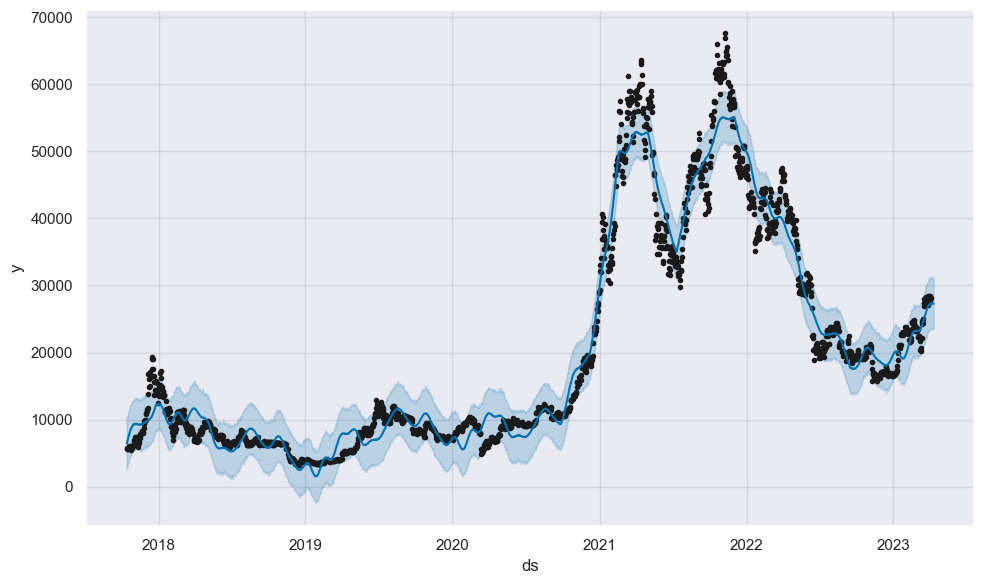

In [87]:
fig1 = model.plot(forecast)

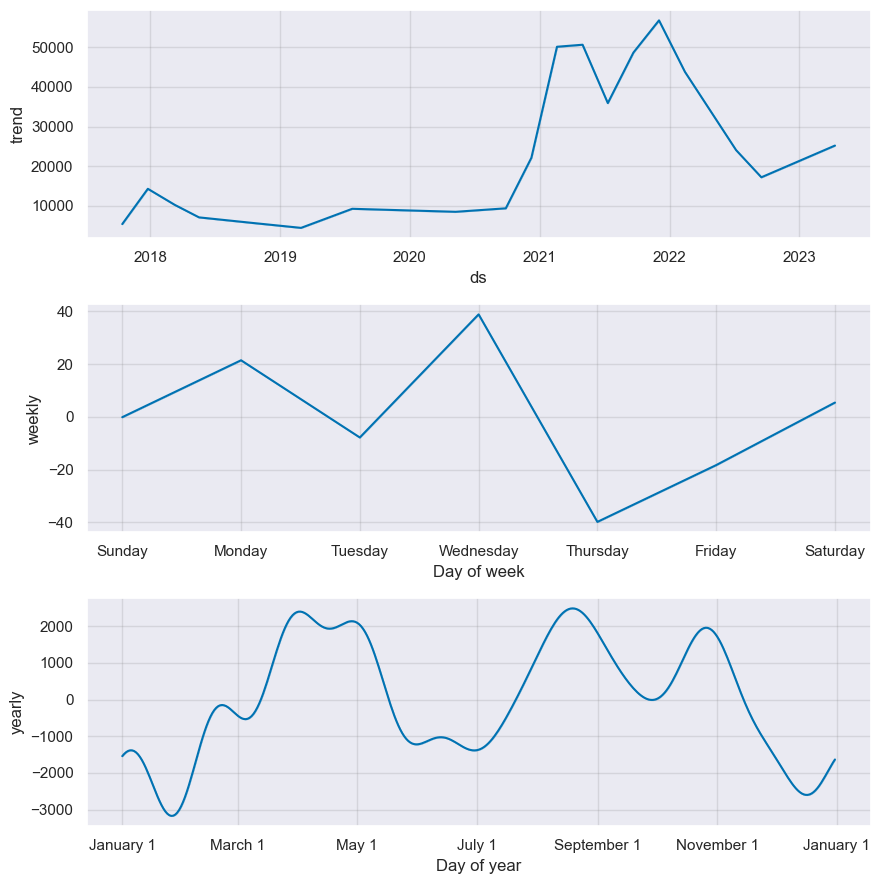

In [88]:
fig2 = model.plot_components(forecast)

Pull data from API - skip step if training the model - only for new predictions

In [96]:
# Twitter API credentials
consumer_key = 'SAeFTrk5BYFbruPg2V8496BfC'
consumer_secret = '5TVLEcQNuqYcbeZ35io8r1bNSp7sbiTTNhXvdmcoN5dS9GFnXg'
access_token = '897170002192846848-5YlxycwLzqWJZDQUVz5lkbqoIzPP40y'
access_token_secret = 'lAMdYG8SfPZMgr3f8nIgvqeByBj1qFNOZ6E4avQ62Z81G'

# Authenticate with the Twitter API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [97]:
# Define search parameters
search_words = "bitcoin"
start_date = dt.datetime.today() - dt.timedelta(days=7) #7
end_date = dt.datetime.today()

In [ ]:
#
tweet_list = []
for day in pd.date_range(start=start_date, end=end_date, freq='D'):
    tweets = tweepy.Cursor(api.search_tweets,
                           q=search_words,
                           lang="en",
                           since_id=day.strftime('%Y-%m-%d'),
                           until=(day + dt.timedelta(days=1)).strftime('%Y-%m-%d')).items(100)

    for tweet in tweets:
        tweet_list.append([day, tweet.text])